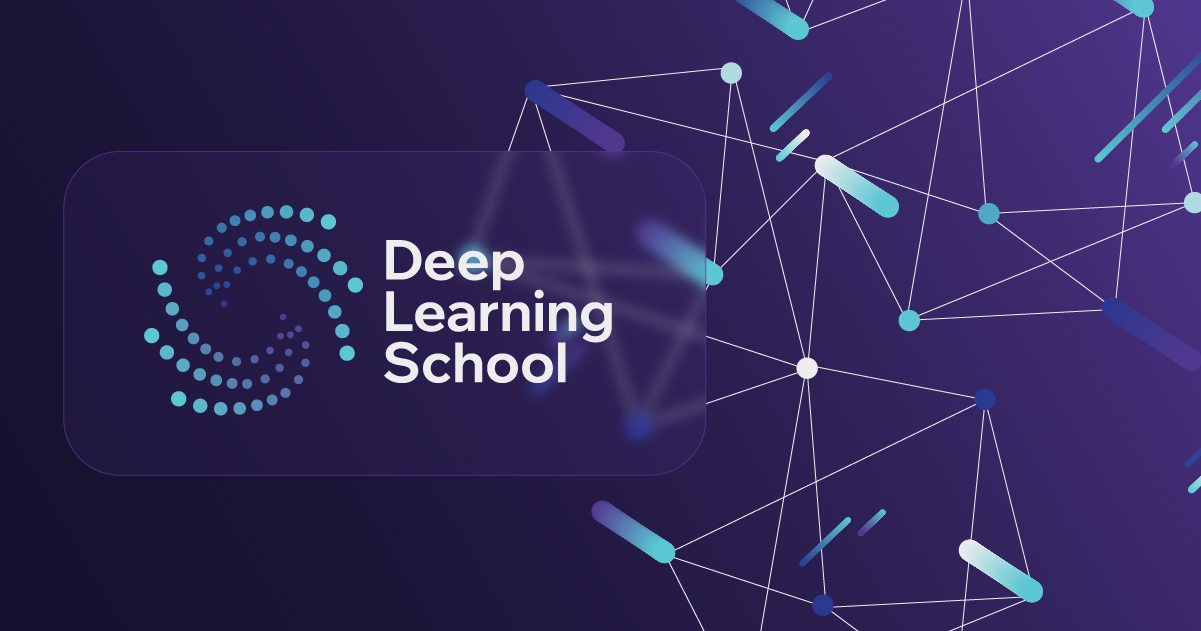

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h1>



В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
import random

sns.set(style="darkgrid", font_scale=1.4)

In [2]:
# Reduce stochasticity

SEED = 42

# PyTorch
torch.manual_seed(SEED)

# CUDA (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups

# NumPy
np.random.seed(SEED)

# Python's built-in random
random.seed(SEED)

In [3]:
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [4]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

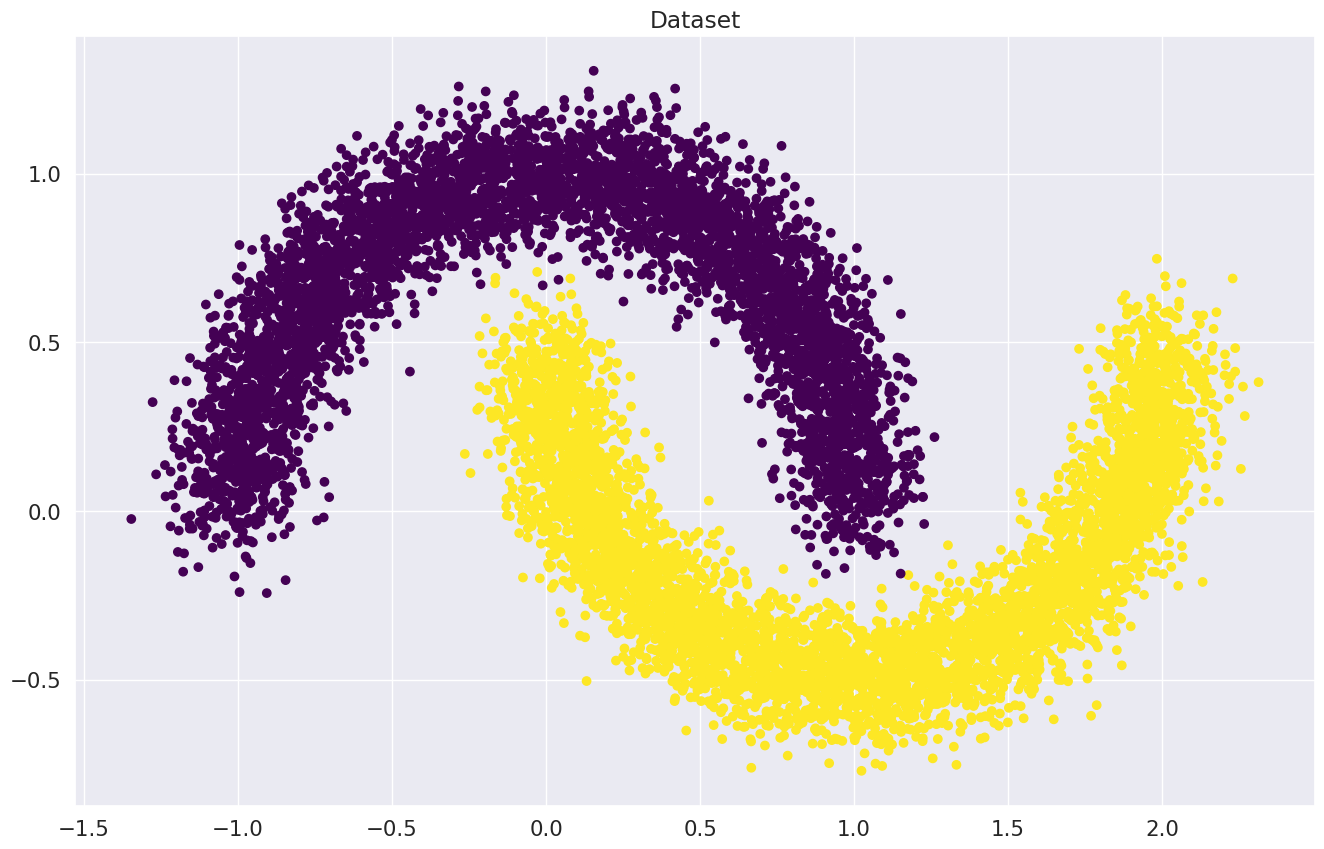

In [5]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [7]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_val_t =  torch.tensor(X_val, dtype=torch.float32)
y_val_t =  torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к классу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоида берут:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  torch.matmul(x, self.weights.t())
        if self.bias:
            x +=  self.bias_term
        return x

In [10]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

**Ответ:**

In [11]:
count_parameters = sum(par.numel() for par in linear_regression.parameters())
count_parameters

3

### Train loop

Перейдём непосредственно к обучению.

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обнуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch).squeeze()
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break


Iteration: 0
Batch accuracy: 0.5625
Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 755.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ: 755**

### Визуализируем результаты

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [14]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch).squeeze()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [16]:
from sklearn.metrics import accuracy_score

test_predictions = predict(val_dataloader, linear_regression)
true_labels = np.array([])
for _, y_batch in val_dataloader:
  true_labels = np.hstack((true_labels, y_batch.numpy().flatten()))

accuracy = accuracy_score(true_labels, test_predictions)
print(accuracy)

0.862


**Вопрос 3**

Какое `accuracy` получается после обучения? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ:**

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [17]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.89MB/s]


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.


In [18]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(784, 128),
    activation,

    nn.Linear(128, 128),
    activation,

    nn.Linear(128, 10)
)

Задайте лосс для обучения (кросс-энтропия).

Вспомним, что такое кросс-энтропийная функция потерь:

$$
L = -\frac{1}{N} \sum_{n=1}^{N} \sum_{i=1}^{C} y_{ni} \log(\hat{y}_{ni})
$$

где:
- $N$ — количество объектов в выборке,
- $C$ — количество классов,
- $y_{ni}$ — истинная метка (one-hot представление),
- $\hat{y}_{ni}$ — предсказанная вероятность модели для класса $i$ на примере $n$.

***Пример расчета***

Рассмотрим пример расчета кросс-энтропийной функции потерь для задачи многоклассовой классификации с 10 классами. Предположим, что у нас есть один объект, истинный класс которого известен, а модель выдала свои предсказания в виде вероятностей для каждого класса.

Пусть объект является цифрой 2. Тогда:
     $$
     y = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
     $$

Пусть модель выдала следующие вероятности для 10 классов:  
     $$
     \hat{y} = [0.1, 0.05, 0.6, 0.15, 0.05, 0.02, 0.01, 0.01, 0.01, 0.0]
     $$

$$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$



Только один элемент $y_i$ равен 1, остальные равны 0. Поэтому:

$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i) = - y_2 \cdot log(\hat{y}_2) = - 1 \cdot log(0.6) \approx 0.51
$

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
device

'cuda'

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [22]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                  outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.881
Loader: valid. Accuracy: 0.9282
Epoch: 2
Loader: train. Accuracy: 0.9423833333333334
Loader: valid. Accuracy: 0.9498
Epoch: 3
Loader: train. Accuracy: 0.9586333333333333
Loader: valid. Accuracy: 0.9585
Epoch: 4
Loader: train. Accuracy: 0.9674
Loader: valid. Accuracy: 0.9624
Epoch: 5
Loader: train. Accuracy: 0.97415
Loader: valid. Accuracy: 0.9648
Epoch: 6
Loader: train. Accuracy: 0.9793666666666667
Loader: valid. Accuracy: 0.9666
Epoch: 7
Loader: train. Accuracy: 0.9827
Loader: valid. Accuracy: 0.9702
Epoch: 8
Loader: train. Accuracy: 0.9851833333333333
Loader: valid. Accuracy: 0.9695
Epoch: 9
Loader: train. Accuracy: 0.9867333333333334
Loader: valid. Accuracy: 0.9693
Epoch: 10
Loader: train. Accuracy: 0.9861166666666666
Loader: valid. Accuracy: 0.9718


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

Функции активации добавляют ***нелинейность в модель***, что позволяет сети решать сложные задачи, такие как классификация и регрессия. Без функций активации нейронная сеть была бы линейной моделью, так как ***композиция линейных преобразований*** это ***линейное преобразование***.

**ReLU (Rectified Linear Unit)**
   - Формула: $ f(x) = \max(0, x) $
   - Диапазон значений: $ [0, \infty) $

**Leaky ReLU**
   - Формула: $ f(x) = \max(\alpha x, x) $, где $ \alpha $ — маленькое положительное число (обычно $ \alpha = 0.01 $).
   - Диапазон значений: $ (-\infty, \infty) $

**Exponential Linear Unit (ELU)**
   - Формула:
   $f(x) = $
     \begin{cases}
     x & \text{если } x > 0 \\
     \alpha (e^x - 1) & \text{если } x \leq 0
     \end{cases}
   - Диапазон значений:  $ (-\alpha, \infty) $

**Линейная функция активации**
   - Формула: $ f(x) = x $
   - Диапазон значений: $ (-\infty, \infty) $

   Обратите внимание, что данная функция активации **не добавляет** нелинейности.

In [23]:
elu_accuracy = accuracy["valid"]

In [24]:
def test_activation_function(activation_cls, max_epochs=10):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation_cls(),
        nn.Linear(128, 128),
        activation_cls(),
        nn.Linear(128, 10)
    )

    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
            torch.nn.init.zeros_(m.bias)
    model.apply(init_weights)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    accuracy = {"valid": []}

    for epoch in range(max_epochs):
        model.train()
        for x_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            outp = model(x_batch)
            loss = criterion(outp, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        epoch_correct = 0
        epoch_all = 0
        with torch.no_grad():
            for x_batch, y_batch in valid_dataloader:
                outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all

        accuracy["valid"].append(epoch_correct / epoch_all)

    return accuracy["valid"]


In [25]:
plain_accuracy = test_activation_function(nn.Identity)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(lambda: nn.LeakyReLU(0.01))
elu_accuracy = test_activation_function(nn.ELU)

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

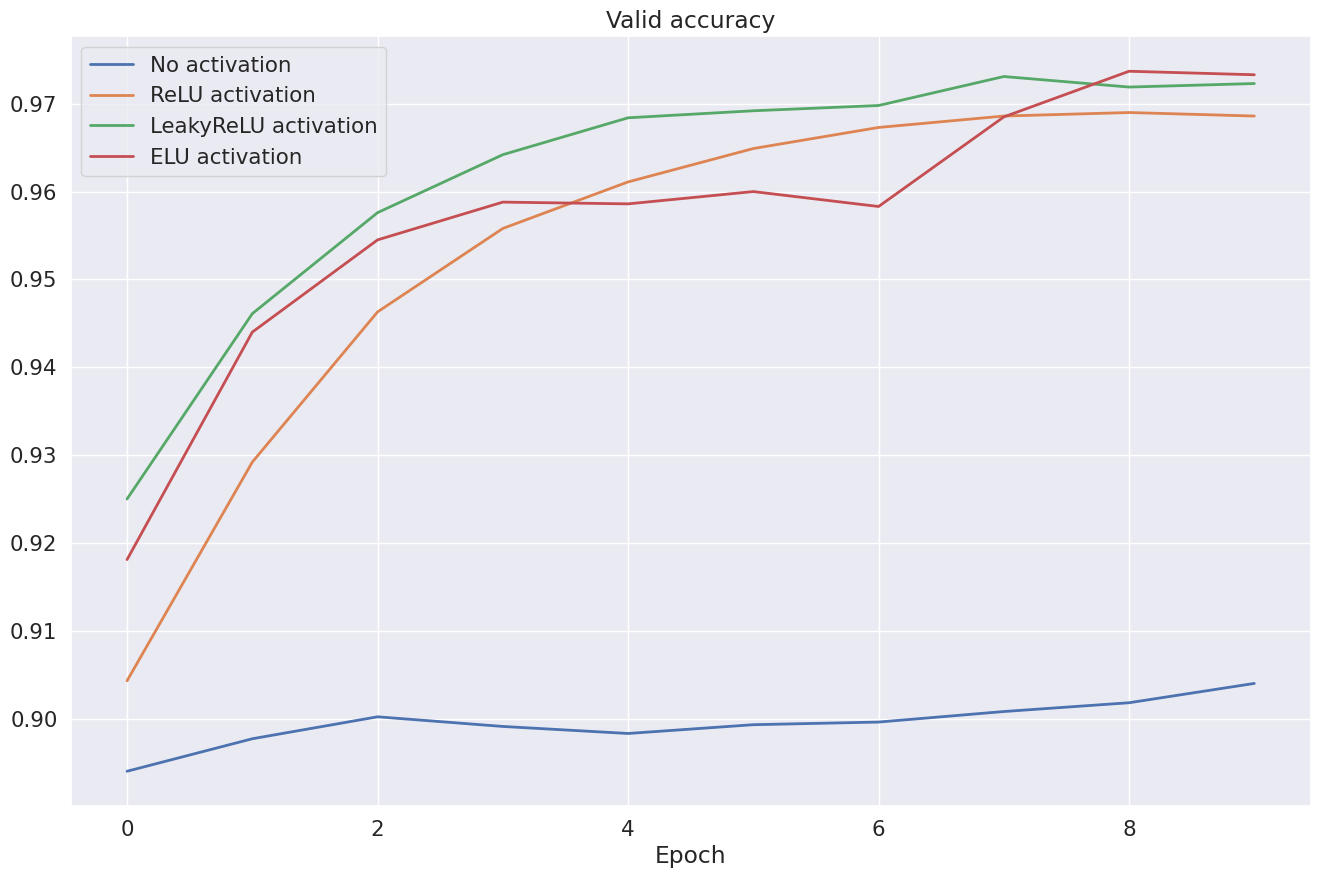

In [26]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [27]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ: ReLU**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [28]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2025-04-07 16:56:13--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   234KB/s    in 0.2s    

2025-04-07 16:56:13 (234 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



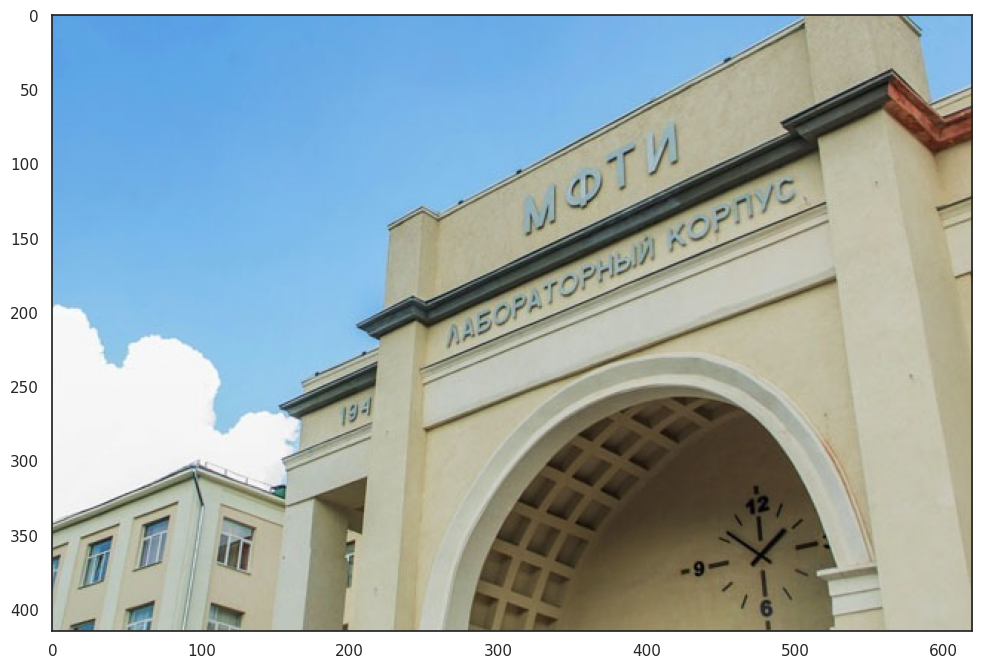

In [29]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [30]:
kernels = {
    'A': np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]),  # Ядро А
    'B': np.array([[0, 1, 0], [0, -2, 0], [0, 1, 0]]),  # Ядро Б
    'C': np.array([[0, 0, 0], [1, -2, 1], [0, 0, 0]]),  # Ядро В
    'D': np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]),  # Ядро Г
    'E': np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]), # Ядро Д
    'F': np.array([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]])  # Ядро E
}

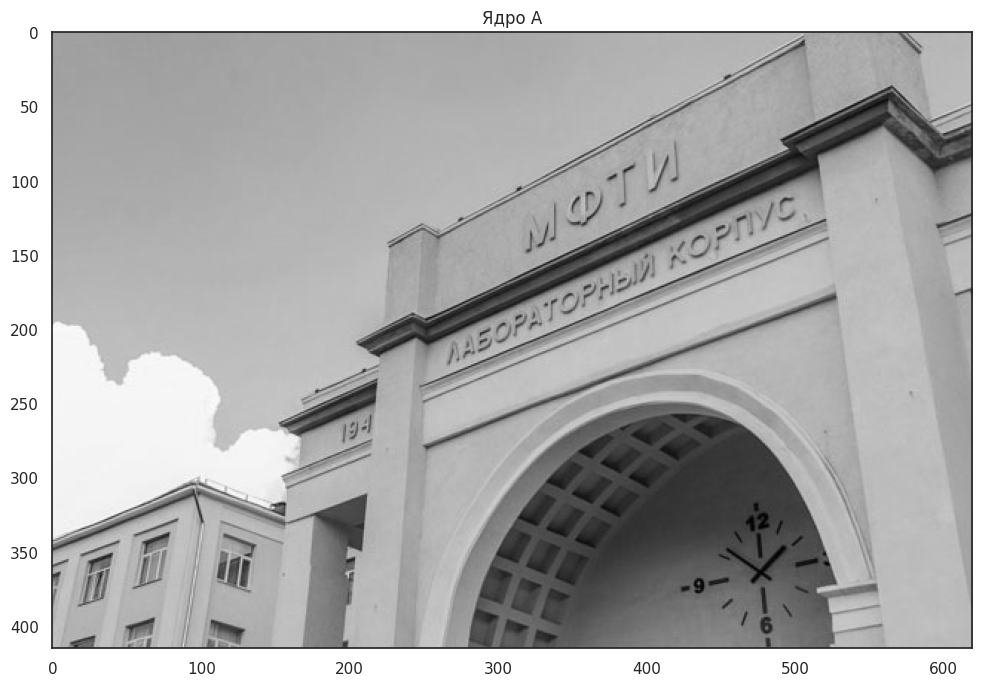

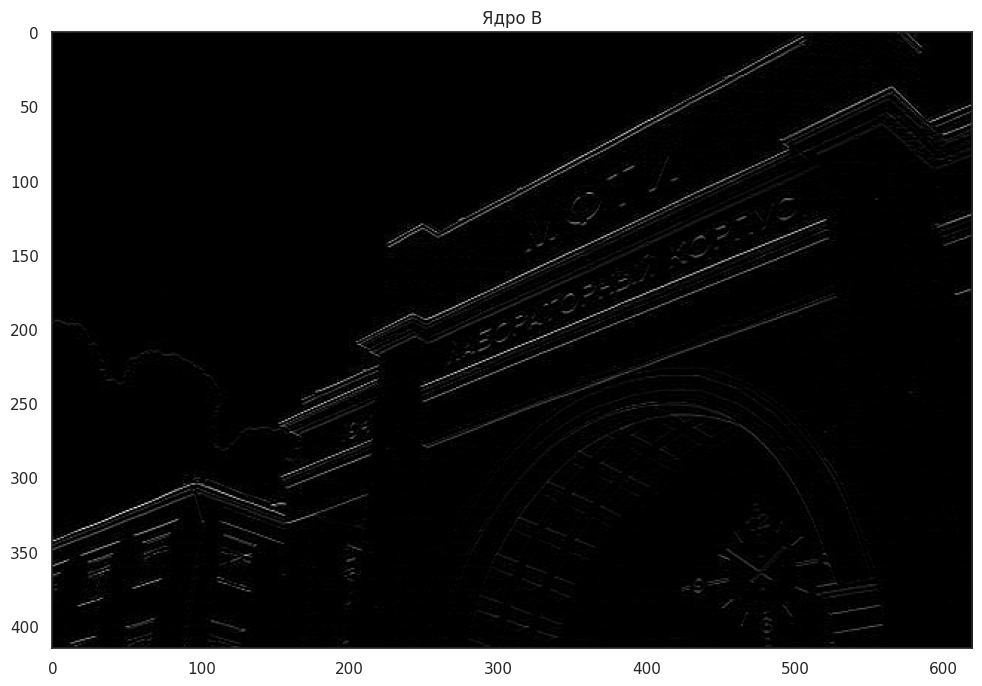

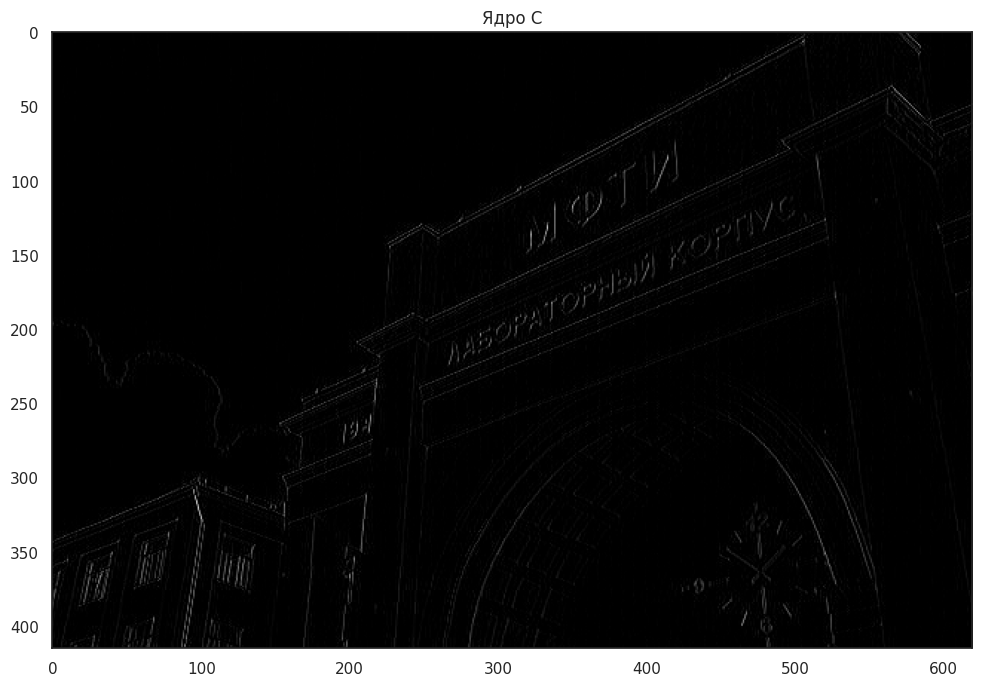

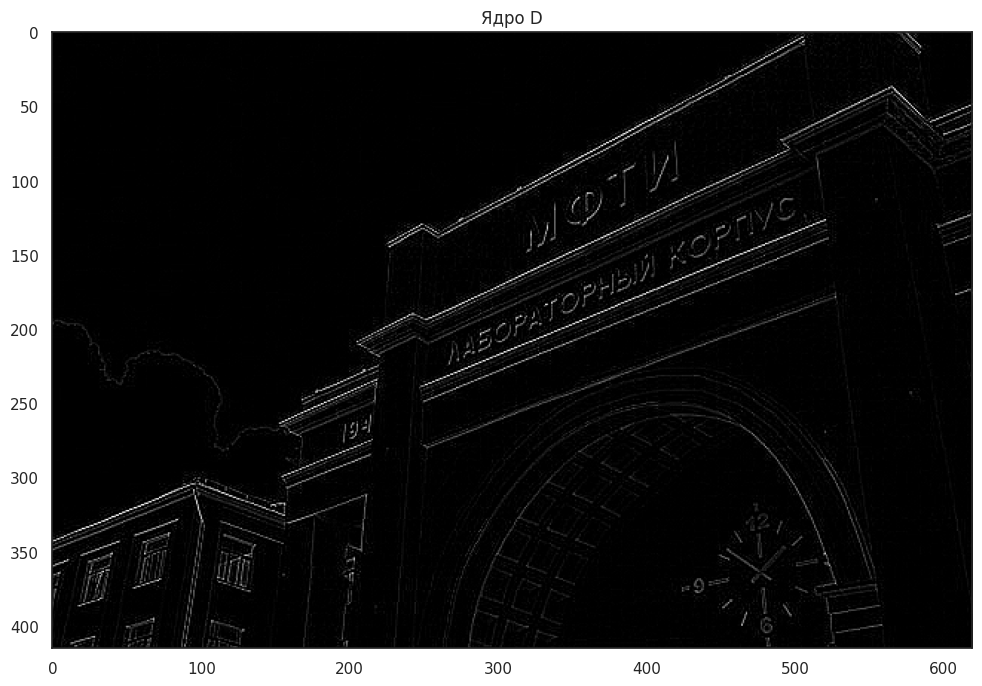

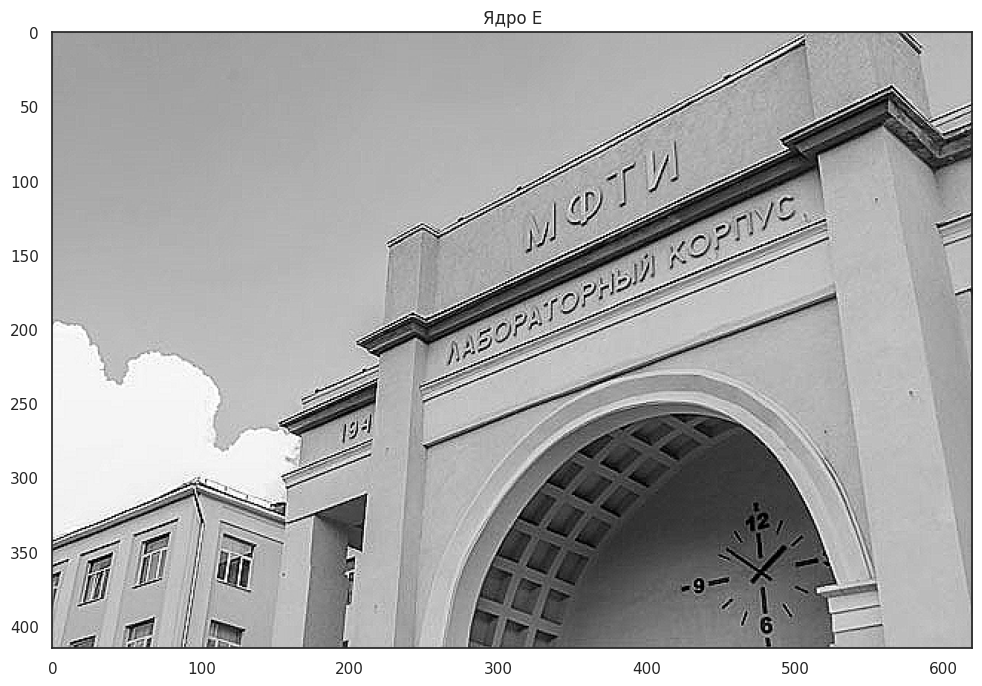

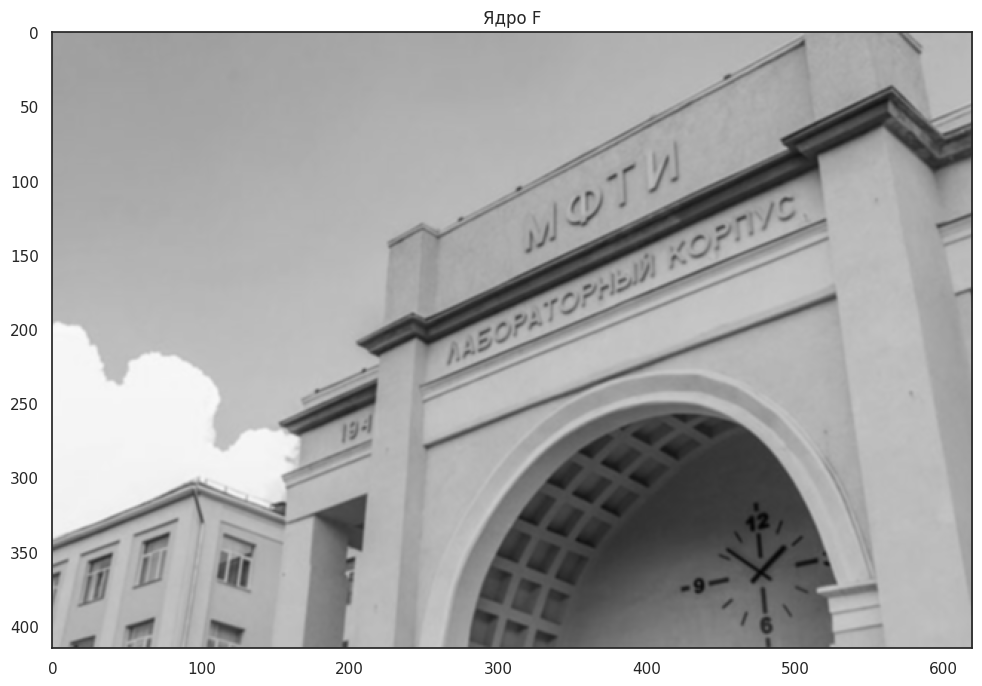

In [31]:
# Преобразование изображения в тензор
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]

# Применение каждого ядра к изображению
for name, kernel in kernels.items():
    # Преобразование ядра в тензор
    kernel_t = torch.tensor(kernel).reshape(1, 1, 3, 3).type(torch.float32)
    kernel_t = kernel_t.repeat(3, 3, 1, 1)  # Повторяем ядро для всех каналов
    padded_img_t = nn.ReflectionPad2d(1)(img_t)

    # Применяем свертку
    result = F.conv2d(padded_img_t, kernel_t)[0]


    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    # Визуализация результата
    plt.figure(figsize=(12, 8))
    plt.title(f"Ядро {name}")
    plt.imshow(result_np)
    plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ: 1 - F, 2 - E, 3 - A, 4 - C, 5 - B, 6 - D**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [37]:
class LeNet(nn.Module):
    def __init__(self, activation=None):
        super(LeNet, self).__init__()

        # Свёрточные слои
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3)  # 1 входной канал (ч/б), 6 выходных, ядро 3x3
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3)  # 6 входных, 16 выходных, ядро 3x3

        # Пулинговые слои (уменьшение размерности)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Размер окна 2x2, шаг 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Полносвязные слои
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 16*5*5 входов (после пулинга), 120 выходов
        self.fc2 = nn.Linear(120, 84)           # 120 входов, 84 выхода
        self.fc3 = nn.Linear(84, 10)            # 84 входа, 10 выходов (10 классов)

        # Функция активации (по умолчанию - Identity)
        self.activation = activation if activation is not None else nn.Identity()

    def forward(self, x):
        # Первый свёрточный блок: conv -> активация -> пулинг
        x = self.conv1(x)       # Применяем свёртку
        x = self.activation(x)   # Применяем активацию
        x = self.pool1(x)       # Применяем пулинг

        # Второй свёрточный блок
        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool2(x)

        # Преобразуем тензор в вектор для полносвязных слоёв
        x = torch.flatten(x, 1)  # Вытягиваем все измерения, кроме batch

        # Полносвязные слои с активацией
        x = self.fc1(x)
        x = self.activation(x)

        x = self.fc2(x)
        x = self.activation(x)

        # Выходной слой (без активации, так как используется CrossEntropyLoss)
        x = self.fc3(x)

        return x

In [38]:
model = LeNet().to(device)

# Критерий и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Словарь с загрузчиками данных
loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet_accuracy = accuracy["valid"]
torch.use_deterministic_algorithms(False)

In [46]:
def test_activation_function(activation, max_epochs=10):
    model = LeNet(activation=activation).to(device)  # Передаём активацию и переносим модель на device

    # Инициализация весов для всех слоёв
    def init_weights(m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(m.weight, mean=0.0, std=0.01)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
    model.apply(init_weights)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    valid_accuracy = []

    for epoch in range(max_epochs):
        model.train()
        for x_batch, y_batch in train_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Перенос данных на device
            optimizer.zero_grad()
            outp = model(x_batch)
            loss = criterion(outp, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x_batch, y_batch in valid_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outp = model(x_batch)
                preds = outp.argmax(-1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        epoch_accuracy = correct / total
        valid_accuracy.append(epoch_accuracy)
        print(f"Epoch {epoch+1}/{max_epochs}, Valid Accuracy: {epoch_accuracy:.4f}")

    return valid_accuracy

In [47]:
lenet_accuracy = test_activation_function(nn.Identity())  # Линейная функция активации (без нелинейности)
relu_accuracy = test_activation_function(nn.ReLU())  # ReLU
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU(0.01))  # Leaky ReLU
elu_accuracy = test_activation_function(nn.ELU())

Epoch 1/10, Valid Accuracy: 0.9308
Epoch 2/10, Valid Accuracy: 0.9542
Epoch 3/10, Valid Accuracy: 0.9678
Epoch 4/10, Valid Accuracy: 0.9725
Epoch 5/10, Valid Accuracy: 0.9741
Epoch 6/10, Valid Accuracy: 0.9734
Epoch 7/10, Valid Accuracy: 0.9740
Epoch 8/10, Valid Accuracy: 0.9753
Epoch 9/10, Valid Accuracy: 0.9760
Epoch 10/10, Valid Accuracy: 0.9766
Epoch 1/10, Valid Accuracy: 0.8822
Epoch 2/10, Valid Accuracy: 0.9443
Epoch 3/10, Valid Accuracy: 0.9623
Epoch 4/10, Valid Accuracy: 0.9705
Epoch 5/10, Valid Accuracy: 0.9750
Epoch 6/10, Valid Accuracy: 0.9771
Epoch 7/10, Valid Accuracy: 0.9798
Epoch 8/10, Valid Accuracy: 0.9805
Epoch 9/10, Valid Accuracy: 0.9814
Epoch 10/10, Valid Accuracy: 0.9819
Epoch 1/10, Valid Accuracy: 0.9329
Epoch 2/10, Valid Accuracy: 0.9650
Epoch 3/10, Valid Accuracy: 0.9742
Epoch 4/10, Valid Accuracy: 0.9791
Epoch 5/10, Valid Accuracy: 0.9815
Epoch 6/10, Valid Accuracy: 0.9815
Epoch 7/10, Valid Accuracy: 0.9810
Epoch 8/10, Valid Accuracy: 0.9825
Epoch 9/10, Valid 

Сравним с предыдущем пунктом

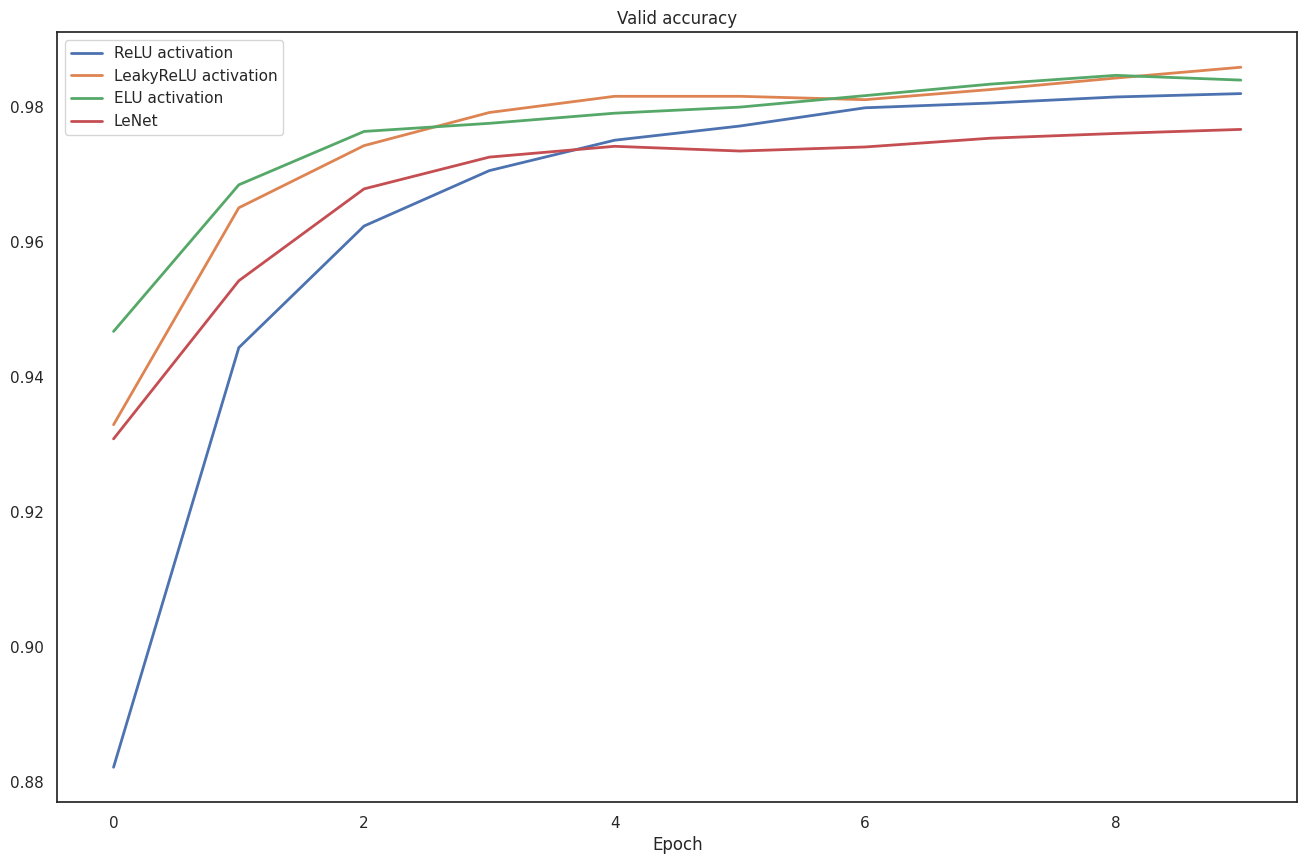

In [48]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ: ReLU 0.98**